### Imports

In [1]:
# ==============================================================
#                    Made by Daniel Cada
# ==============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),      
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

dataset = datasets.ImageFolder(root="../Pre-processing/dataset/face_dataset/", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)


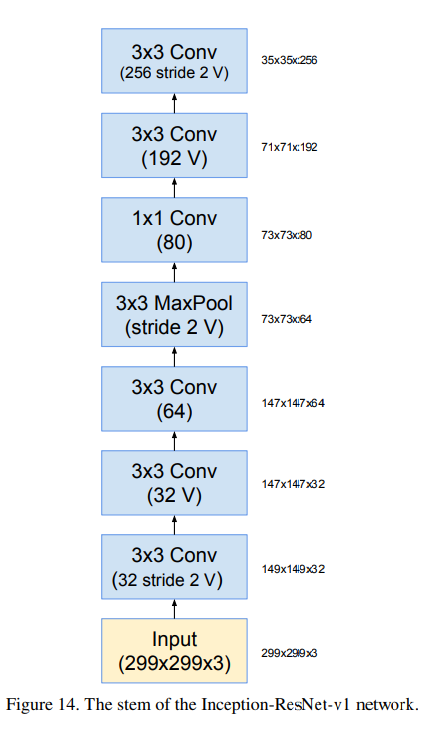

In [3]:
###
# Def Inception_Stem The stem from Incetion-ResNet-v1
# input_shape - The shape of our input image (height, width, channels)
# Returns - The tensor after passing through the stem block.
###
class Inception_stem(nn.Module):
    def __init__(self, input_channels=3):
        super(Inception_stem, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        self.conv4 = nn.Conv2d(64, 80, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(80, 192, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv2d(192, 256, kernel_size=3, stride=2, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.relu(self.conv1(x))  # Output: 149x149x32
        x = self.relu(self.conv2(x))  # Output: 147x147x32
        x = self.relu(self.conv3(x))  # Output: 147x147x64
        x = self.maxpool(x)           # Output: 73x73x64
        x = self.relu(self.conv4(x))  # Output: 73x73x80
        x = self.relu(self.conv5(x))  # Output: 71x71x192
        x = self.relu(self.conv6(x))  # Output: 35x35x256
        return x

input_tensor = torch.randn(3, 299, 299)
model = Inception_stem(input_channels=3)
output = model(input_tensor)
print("outputShape: ", output.shape)


outputShape:  torch.Size([256, 35, 35])


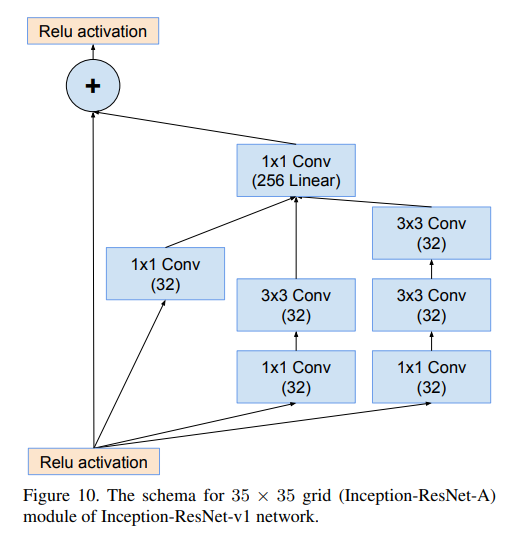

In [4]:
### 
# InceptionResNetABlock: Defines one Inception-ResNet-A block of size 35x35
# filters - The amount of filters for the convolutions
# Returns - The tensor after the A block
###
class InceptionResNet_A_Block(nn.Module):
    def __init__(self, in_channel, filters=32):
        super(InceptionResNet_A_Block, self).__init__()

        # Branch 1
        self.branch1 = nn.Conv2d(in_channel, filters, kernel_size=1, stride=1, padding=0)

        # Branch 2
        self.branch2_1 = nn.Conv2d(in_channel, filters, kernel_size=1, stride=1, padding=0)
        self.branch2_2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)

        # Branch 3
        self.branch3_1 = nn.Conv2d(in_channel, filters, kernel_size=1, stride=1, padding=0)
        self.branch3_2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        self.branch3_3 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)

        self.reduced_conv = nn.Conv2d(filters*3, in_channel, kernel_size=1, stride=1, padding=0) # (*3 because 3 dimensions)
        self.relu = nn.ReLU()

    def forward(self, x):

        # Branch 1
        branch_1 = self.relu(self.branch1(x))

        # Branch 2
        branch_2 = self.relu(self.branch2_1(x))
        branch_2 = self.relu(self.branch2_2(branch_2))

        # Branch 3
        branch_3 = self.relu(self.branch3_1(x))
        branch_3 = self.relu(self.branch3_2(branch_3))
        branch_3 = self.relu(self.branch3_3(branch_3))

        # Concatenate all branches along the channel dimension
        mixed = torch.cat([branch_1, branch_2, branch_3], dim=1)

        reduced = self.reduced_conv(mixed)
        output = torch.add(x, reduced)
        output = self.relu(output)

        return output
    
input_tensor = torch.randn(1, 256, 35, 35)
model = InceptionResNet_A_Block(in_channel=256)
output = model(input_tensor)
print("outputShape: ", output.shape)


outputShape:  torch.Size([1, 256, 35, 35])


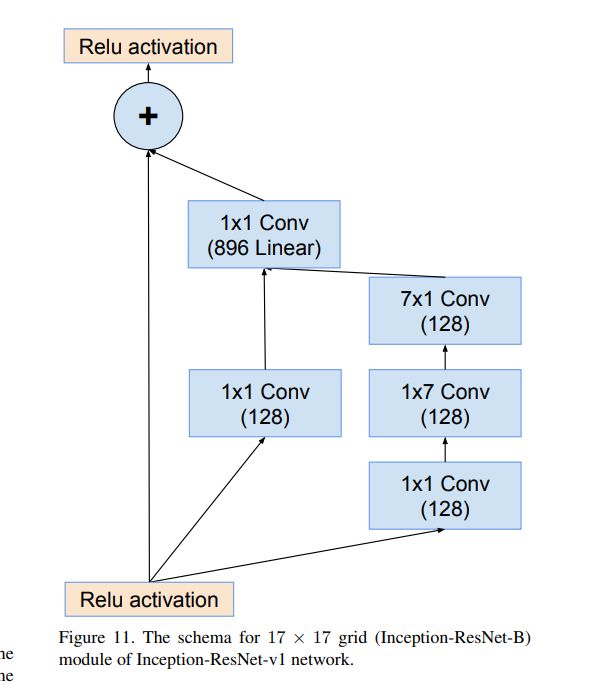

In [5]:
### 
# InceptionResNet_B_Block: Defines one Inception-ResNet-B block of size 17x17
# filters - The amount of filters for the convolutions
# in_channels - The amount of input channels
# Returns - The tensor after the B block
### 
class InceptionResNet_B_Block(nn.Module):
    def __init__(self, in_channels, filters=32):
        super(InceptionResNet_B_Block, self).__init__()

        # Branch 1
        self.branch1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)

        # Branch 2
        self.branch2_1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)
        self.branch2_2 = nn.Conv2d(filters, filters, kernel_size=(1,7), stride=1, padding=(0,3))
        self.branch2_3 = nn.Conv2d(filters, filters, kernel_size=(7,1), stride=1, padding=(3,0))

        self.reduced_conv = nn.Conv2d(filters*2, in_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Branch 1
        branch_1 = self.relu(self.branch1(x))

        # Branch 2
        branch_2 = self.relu(self.branch2_1(x))
        branch_2 = self.relu(self.branch2_2(branch_2))

        # Concatenate
        mixed = torch.cat([branch_1, branch_2], dim=1)

        reduced = self.reduced_conv(mixed)
        output = torch.add(x, reduced)
        output = self.relu(output)

        return output

input_tensor = torch.randn(1, 896, 17, 17)
model = InceptionResNet_B_Block(in_channels=896)
output = model(input_tensor)
print("outputShape: ", output.shape)

outputShape:  torch.Size([1, 896, 17, 17])


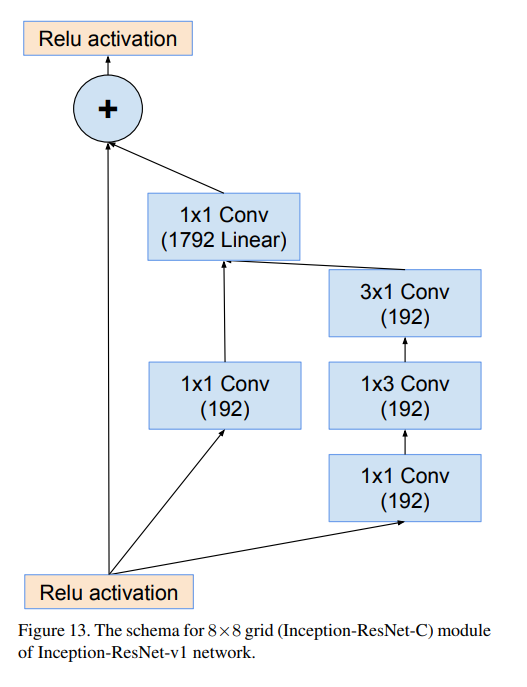

In [6]:
### 
# InceptionResNet_C_Block: Defines one Inception-ResNet-C block of size 8x8
# in_channels - The amount of input channels
# filters - The amount of filters for the convolutions
# Returns - The tensor after the C block
###
class InceptionResNet_C_Block(nn.Module):
    def __init__(self, in_channels=1792, filters=32):
        super(InceptionResNet_C_Block, self).__init__()

        # Branch 1
        self.branch_1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)

        # Branch 2 NOTE: Kanske ska ha större filterstorlek?
        self.branch_2_1 = nn.Conv2d(in_channels, filters, kernel_size=1, stride=1, padding=0)
        self.branch_2_2 = nn.Conv2d(filters, filters, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch_2_3 = nn.Conv2d(filters, filters, kernel_size=(3, 1), stride=1, padding=(1, 0))

        # 1x1 Convolution to reduce dimensions
        self.reduced = nn.Conv2d(filters*2, 1792, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Branch 1
        branch_1 = self.branch_1(x)

        # Branch 2
        branch_2 = self.branch_2_1(x)
        branch_2 = self.branch_2_2(branch_2)
        branch_2 = self.branch_2_3(branch_2)

        # Concatenate
        mixed = torch.cat([branch_1, branch_2], dim=1)
        reduced = self.reduced(mixed)
        output = x + reduced
        output = F.relu(output)

        return output
    
input_tensor = torch.randn(1, 1792, 8, 8)
model = InceptionResNet_C_Block(in_channels=1792)
output = model(input_tensor)
print("outputShape: ", output.shape)

outputShape:  torch.Size([1, 1792, 8, 8])


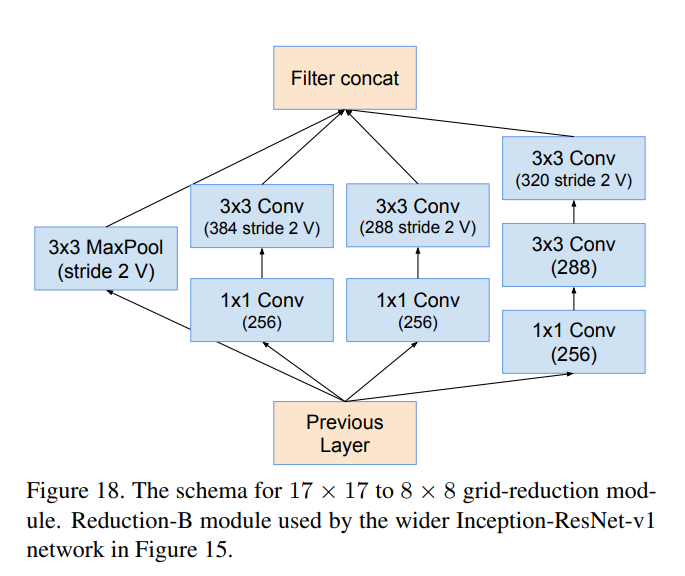

In [7]:
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super(ReductionB, self).__init__()

        # Branch 1
        self.branch1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # Branch 2
        self.branch2_1 = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.branch2_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0)

        # Branch 3
        self.branch3_1 = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.branch3_2 = nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1)
        self.branch3_3 = nn.Conv2d(192, 320, kernel_size=3, stride=2, padding=0)

        # Branch 4
        self.branch4_1 = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.branch4_2 = nn.Conv2d(128, 320, kernel_size=3, stride=2, padding=0)

    def forward(self, x):

        branch1 = self.branch1(x)
        branch2 = self.branch2_2(self.branch2_1(x))
        branch3 = self.branch3_3(self.branch3_2(self.branch3_1(x)))
        branch4 = self.branch4_2(self.branch4_1(x))

        # Concatenate
        output = torch.cat([branch1, branch2, branch3, branch4], dim=1)

        return output

input_tensor = torch.randn(1, 896, 17, 17)
reduction_b = ReductionB(in_channels=896)
output = reduction_b(input_tensor)
# Should be (8 x 8 x 1792)
print(output.shape)


torch.Size([1, 1792, 8, 8])


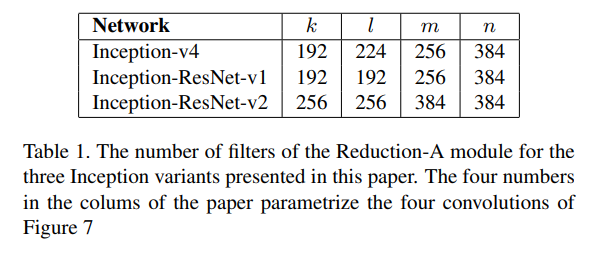

In [ ]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k=192, l=192, m=256, n=384):
        super(ReductionA, self).__init__()

        # Branch 1: 3x3 Max Pooling
        self.branch1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # Branch 2: 3x3 Convolution with stride 2
        self.branch2 = nn.Conv2d(in_channels, n, kernel_size=3, stride=2, padding=0)

        # Branch 3: 1x1 -> 3x3 -> 3x3 Convolutions with stride 2
        self.branch3_1 = nn.Conv2d(in_channels, k, kernel_size=1, stride=1, padding=0)
        self.branch3_2 = nn.Conv2d(k, l, kernel_size=3, stride=1, padding=1)
        self.branch3_3 = nn.Conv2d(l, m, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        # Process each branch
        branch1 = self.branch1(x)  # Max pooling
        branch2 = self.branch2(x)  # Convolution
        branch3 = self.branch3_3(self.branch3_2(self.branch3_1(x)))  # Triple convolution

        # Concatenate branches along the channel dimension
        return torch.cat([branch1, branch2, branch3], dim=1)


input_tensor = torch.randn(1, 256, 35, 35)
reduction_a = ReductionA(in_channels=256, k=192, l=192, m=256, n=384)
output = reduction_a(input_tensor)
# Should be (17, 17)
print(output.shape)


torch.Size([1, 896, 17, 17])


In [9]:
### 
# FullyConnectedLayer: Adds a fully connected layer with dropout
# in_channels - The amount of input channels
# feature_dim: d from article
# dropout_rate: The dropout rate
# returns - the tensor after the FCL
###
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_channels, feature_dim, dropout_rate=0.8):
        super(FullyConnectedLayer, self).__init__()

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_channels, feature_dim)

    def forward(self, x):
        x = self.global_avg_pool(x)

        # Flatten [batch_size, channels, 1, 1] to [batch_size, channels]
        x = torch.flatten(x, 1) 
        x = self.dropout(x)
        x = self.fc(x)

        return x

batch_size = 1
channels = 1792  
height = 8     
width = 8  
feature_dim = 128

input_tensor = torch.randn(batch_size, channels, height, width)
model = FullyConnectedLayer(in_channels=channels, feature_dim=feature_dim)
output = model(input_tensor)
print(f"Output shape: {output.shape}")



Output shape: torch.Size([1, 128])


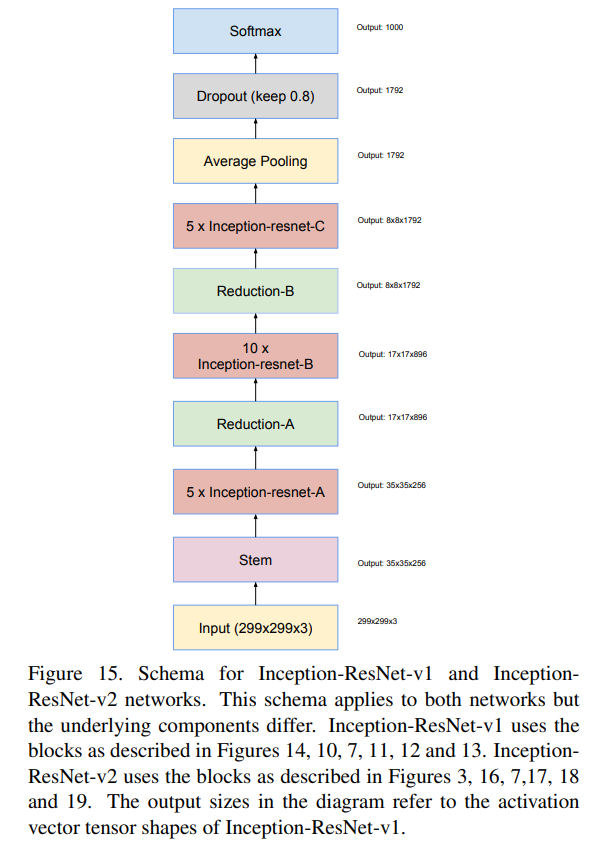

In [ ]:
###
# feature_net: Implements the feature net from BioMetricNet: https://arxiv.org/pdf/2008.06021
# input_shape: The shape of the images as inputs, in the paper they use 299, 299, 3
# feature_dim: The size of the output feature vector (d), see paper
# dropout_rate: The dropout rate (reduces overfitting by randomly dropping neurons during training, ensuring the network generalizes well)
###
class FeatureNet(nn.Module):
    def __init__(self, feature_dim=512, dropout_rate=0.8):
        super(FeatureNet, self).__init__()

        self.inception_stem = Inception_stem()

        self.inception_resnet_a_blocks = nn.ModuleList([
            InceptionResNet_A_Block(in_channel=256, filters=32) for _ in range(2)
        ])
        
        self.reduction_a = ReductionA(in_channels=256, k=192, l=192, m=256, n=384)
        
        self.inception_resnet_b_blocks = nn.ModuleList([
            InceptionResNet_B_Block(in_channels=896, filters=32) for _ in range(4)
        ])

        self.reduction_b = ReductionB(in_channels=896)

        self.inception_resnet_c_blocks = nn.ModuleList([
            InceptionResNet_C_Block(in_channels=1792, filters=32) for _ in range(2)
        ])

        self.fc_layer = FullyConnectedLayer(in_channels=1792, feature_dim=feature_dim, dropout_rate=dropout_rate)

    def forward(self, x):

        x = self.inception_stem(x)

        for block in self.inception_resnet_a_blocks:
            x = block(x)
        
            
        x = self.reduction_a(x)

        for block in self.inception_resnet_b_blocks:
            x = block(x)

        x = self.reduction_b(x)

        for block in self.inception_resnet_c_blocks:
            x = block(x)

        x = self.fc_layer(x)
        
        return x

input_tensor = torch.randn(1, 3, 299, 299)
model = FeatureNet(feature_dim=512)
output = model(input_tensor)
print(output.shape)


torch.Size([1, 512])


In [11]:
# ==============================================================
#                    Made by Oscar Boman
# ==============================================================


class MetricNet(nn.Module):
    def __init__(self, input_size, num_classes=(False, 10), p=1):
        super().__init__()
        
        hidden_size1 = int(input_size/2)
        hidden_size2 = int(input_size/4)
        hidden_size3 = int(input_size/8)
        hidden_size4 = int(input_size/16)
        hidden_size5 = int(input_size/32)
        
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, hidden_size3)
        self.fc5 = nn.Linear(hidden_size3, hidden_size4)
        self.fc6 = nn.Linear(hidden_size4, hidden_size5)
        if num_classes[0]:

            self.fc7 = nn.Linear(hidden_size5, num_classes[1])
        else:

            self.fc7 = nn.Linear(hidden_size5, p)
        
        
        self.relu = nn.ReLU()

        # TESTING ONLY
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x

In [12]:
from bioNet import BioNet, BioNetLoss, threshold

# from the article
mu_n = torch.tensor([40])
mu_m = torch.tensor([0])
sigma = torch.tensor([[1.0]])
p = torch.tensor([1])

num_samples = 100 
z_sn = mu_n + torch.randn(num_samples, p)
z_sm = mu_m +  torch.randn(num_samples, p )

loss_function = BioNetLoss(p)

loss = loss_function(mu_n, z_sn, mu_m, z_sm, sigma)
print(f"Loss: {loss.item()}")

threshold_value = threshold(mu_n, mu_m)
print(f"Threshold: {threshold_value.item()}")

ImportError: cannot import name 'threshold' from 'bioNet' (c:\Users\danie\Documents\GitHub\Learning-face-recognition-from-anchor-points\Model\bioNet.py)

In [ ]:
input_tensor = torch.randn(2, 3, 299, 299)
model = BioNet()
output = model(input_tensor)
print("outputShape: ", output.shape)
print(output)


torch.Size([1, 3, 299, 299])
torch.Size([1, 3, 299, 299])
torch.Size([1, 1024])
outputShape:  torch.Size([1])
tensor([-0.1544], grad_fn=<SelectBackward0>)
